This notebook contains a detailed description of the data cleaning process and the exploratory data analysis (EDA).<br><br> 
The **goal** of this analysis is to select or engineer features that can be used to predict fraud. <br> These features will be summarized in a new data frame that can be used for modelling. 

**Contents**

---

1. [**Import Libraries**](#1-import-libraries)
2. [**Get Data**](#get_data)
    *   [Data description](/data/data_description.md)
    *   `df_client`: client data
    *   `df_invoice`: client invoice data 
3. [**Data Cleaning**](#3-data-cleaning)
    *   [Renaming](#renaming)
    *   Check [missing values](#missing-values)
    *   Check [duplicates](#duplicates)
    *   [Data type conversions](#data-type-conversions)
4. [**Exploring Features**](#4-eda---data-exploration)
    *   Feature [`region`](#feature-region)
    *   Feature [`district`](#feature-district)
    *   Feature [`client_category`](#feature-client_category)
    *   Account [`creation date`](#account-creation-date-features) features: [year](#feature-acc_creation_year), [month](#feature-acc_creation_month), [weekday](#feature-acc_creation_weekday)
    *   [`Invoice date`](#invoice-date-features) features 
    *   Feature [`counter_type`](#feature-counter_type)
    *   Feature [`account_duration`](#feature-account_duration)
    *   [`Energy consumption`](#feature-energy-consumption) features 
    *   Feature [`tarif_type`](#feature-tarif_type) (seperately for [electricity](#feature-elec_tarif_type-modecount) and [gas](#feature-gas_tarif_type-modecount) and a new, related feature [`energy_types`](#new-feature-energy_types))
    *   Feature [`counter_status`](#feature-counter_status)
    *   Feature [`counter_code`](#feature-counter_code)
    *  Feature [`counter_coefficient`](#feature-counter_coefficient)
    *  Feature [`counter_number`](#feature-counter_number)

---

# 1. Import libraries 

In [49]:
import os
import sys
from dotenv import load_dotenv

import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# get variables from .env file 
load_dotenv()
project_path = os.getenv('PROJECT_PATH')

# add path to load own functions from .py files in Scrips folder
sys.path.insert(0, project_path + '\Scripts')

from plotting import *
from preprocessing import *


In [51]:
# colors
COLOR_1 = 'steelblue'
RED_COLORS = ['#e3868d', '#E42A38', '#8a010b']  # bright, middle, dark

# fraud values for plots and grouping 
FRAUD_BASELINE:float    # defined at beginning of 4.EDA  
FRAUD_RANGE = 1.5       # +/- range from baseline considered "normal" fraud rate

# list of column names that are used for modelling
CAT_FEATURES = []
NUM_FEATURES = []

<a id='get_data'></a>

# 2. Get data

[Data description](../data/data_description.md)

In [52]:
# import csv data to pandas dataframes
df_client = pd.read_csv('../data/files/client_train.csv', parse_dates=['creation_date'], dayfirst=True, low_memory=False)
df_invoice = pd.read_csv('../data/files/invoice_train.csv', parse_dates=['invoice_date'], dayfirst=False, low_memory=False)

# Dimensions of dfs
print(f'The client data frame has {df_client.shape[0]} rows and {df_client.shape[1]} columns.')
print(f'The invoice data frame has {df_invoice.shape[0]} rows and {df_invoice.shape[1]} columns.')

The client data frame has 135493 rows and 6 columns.
The invoice data frame has 4476749 rows and 16 columns.


In [53]:
df_client.head(2)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0.0
1,69,train_Client_1,11,107,2002-05-29,0.0


In [54]:
df_invoice.head(2)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC


# 3. Data cleaning

## Renaming

In [55]:
# rename columns
df_client.rename({'disrict': 'district',
                  'client_catg': 'client_category'
                  }, axis=1, inplace=True)

df_invoice.rename({'counter_statue': 'counter_status',
                   'reading_remarque': 'remark',
                   'counter_coefficient': 'counter_coeff',                   
                   }, axis=1, inplace=True)

# rename 'consommation' features 1 to 4 to consumption
for i in range(1,5):
   df_invoice.rename({f'consommation_level_{i}': f'consumption_lvl_{i}'}, axis=1, inplace=True)
                      
# remove client_id prefix from observations in client_id column
if isinstance(df_invoice['client_id'][0], str):
   df_invoice['client_id'] = df_invoice.client_id.str.removeprefix('train_Client_').astype(int)
   df_client['client_id'] = df_client.client_id.str.removeprefix('train_Client_').astype(int)

df_client.head(2)

,district,client_id,client_category,region,creation_date,target
0,60,0,11,101,1994-12-31,0.0
1,69,1,11,107,2002-05-29,0.0


## Missing values

In [56]:
# check for missing values
na_client = df_client.isna().sum().sum()
na_invoice = df_invoice.isna().sum().sum()
print(f'There are {na_client} missing values in the client data and {na_invoice} missing values in the invoice data.')

There are 0 missing values in the client data and 0 missing values in the invoice data.


## Duplicates

In [57]:
# check for duplicated values
dupes_client = df_client.duplicated().sum()
dupes_invoice = df_invoice.duplicated().sum()
print(f'There are {dupes_client} duplicated values in the client data and {dupes_invoice} duplicated values in the invoice data.')


There are 0 duplicated values in the client data and 11 duplicated values in the invoice data.


In [58]:
# remove duplicated values and check again
df_invoice.drop_duplicates(inplace=True)
df_invoice.duplicated().sum()

0

## Data type conversions

Check the data type (numeric, categorical) and the format (str, int, float) of the values in each column and do conversions where necessary. <br><br>

**Workflow**

---
1.  Check data type of each column with `.info()`
2.  Check number of unique values for each column with `.nunique()`
    - A small number of unique values (usually) indicates a categorical variable
    - A large number of unique values (usually) indicates a numerical variable
    - To be sure look at the unique values
3. Do data type conversion using the function `convert_column_type` from `preprocessing.py` in Scripts directory
    - first convert column data types to int/str
    - then convert column data to categorical if necessary
* Converting a string variable to a categorical variable will save some memory (esp when there are only a few categories)


### Client data

In [59]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   district         135493 non-null  int64         
 1   client_id        135493 non-null  int32         
 2   client_category  135493 non-null  int64         
 3   region           135493 non-null  int64         
 4   creation_date    135493 non-null  datetime64[ns]
 5   target           135493 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 5.7 MB


In [60]:
# getting unique values for each column to get an idea about numerical/categorical features
df_client.nunique()

district                4
client_id          135493
client_category         3
region                 25
creation_date        8088
target                  2
dtype: int64

All features (except the creation_date) will be converted to categorical type.

In [61]:
# step 1: convert to str
cols_to_str = ['district', 'client_category', 'region', 'client_id']
df_client = convert_column_type(df_client, cols_to_str, str)

# step 1: convert to int
df_client = convert_column_type(df_client, 'target', int)

# step 2: convert to category
df_client = convert_column_type(df_client, cols_to_str, 'category') # for percentage calculations 
df_client = convert_column_type(df_client, 'target', 'category')

# check conversions
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   district         135493 non-null  category      
 1   client_id        135493 non-null  category      
 2   client_category  135493 non-null  category      
 3   region           135493 non-null  category      
 4   creation_date    135493 non-null  datetime64[ns]
 5   target           135493 non-null  category      
dtypes: category(5), datetime64[ns](1)
memory usage: 7.1 MB


### Invoice data

In [62]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476738 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   client_id          int32         
 1   invoice_date       datetime64[ns]
 2   tarif_type         int64         
 3   counter_number     int64         
 4   counter_status     object        
 5   counter_code       int64         
 6   remark             int64         
 7   counter_coeff      int64         
 8   consumption_lvl_1  int64         
 9   consumption_lvl_2  int64         
 10  consumption_lvl_3  int64         
 11  consumption_lvl_4  int64         
 12  old_index          int64         
 13  new_index          int64         
 14  months_number      int64         
 15  counter_type       object        
dtypes: datetime64[ns](1), int32(1), int64(12), object(2)
memory usage: 563.6+ MB


In [63]:
# getting unique values for each column to get an idea about numerical/categorical features
df_invoice.nunique()

client_id            135493
invoice_date           8275
tarif_type               17
counter_number       201893
counter_status           12
counter_code             42
remark                    8
counter_coeff            16
consumption_lvl_1      8295
consumption_lvl_2     12576
consumption_lvl_3      2253
consumption_lvl_4     12075
old_index            155648
new_index            157980
months_number          1370
counter_type              2
dtype: int64

- **Convert to str and category**: <br>['client_id', 'tarif_type', 'counter_status', 'counter_code', 
               'remark', 'counter_coeff', 'old_index', 'new_index', 'counter_type']
- **To be decided**: <br>months_number, counter_number

In [64]:
# step 1: convert to str
cols_to_str = ['client_id', 'tarif_type', 'counter_status', 'counter_code', 
               'remark', 'counter_coeff', 'old_index', 'new_index', 'counter_type']
df_invoice = convert_column_type(df_invoice, cols_to_str, str)

# step 2: convert to category
df_invoice = convert_column_type(df_invoice, cols_to_str, 'category') # for percentage calculations 

df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476738 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   client_id          category      
 1   invoice_date       datetime64[ns]
 2   tarif_type         category      
 3   counter_number     int64         
 4   counter_status     category      
 5   counter_code       category      
 6   remark             category      
 7   counter_coeff      category      
 8   consumption_lvl_1  int64         
 9   consumption_lvl_2  int64         
 10  consumption_lvl_3  int64         
 11  consumption_lvl_4  int64         
 12  old_index          category      
 13  new_index          category      
 14  months_number      int64         
 15  counter_type       category      
dtypes: category(9), datetime64[ns](1), int64(6)
memory usage: 365.6 MB


# 4. EDA - data exploration

## What is the overall fraud rate in the sample? (Baseline)


There are 135493 clients in the sample.
Of those clients 5.58 % show normal and 94.42 % fraudulent activity 
in electricity and/ or gas consumption.


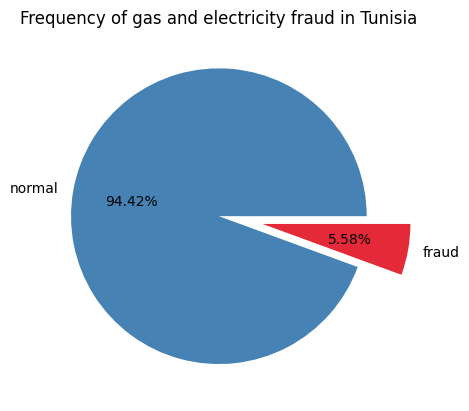

In [65]:
# general information about the data

FRAUD_BASELINE = get_fraud_proportion(df_client) 

print(f'There are {df_client.client_id.nunique()} clients in the sample.')
print(f'Of those clients {round(FRAUD_BASELINE, 2)} % show normal and '
      f'{round(100 - FRAUD_BASELINE, 2)} % fraudulent activity \nin electricity and/ or gas consumption.')

create_fraud_freq_pieplot(df_client)  # function from Scripts/plotting.py

## Explore client data
* features of client data are: `region`, `district`, `client_category` and account creation date
* the client data also contain the `target` that identifies an account with fraudulent (1) or normal (0) energy consumption

**Goal**: Select or create features to model fraud 

**Workflow**: 
1)    Find out how the categories of a feature are related to fraud
   *   Get an overview with the help of a figure using <br> `subplopts_fraud_per_category()` function from `plotting.py` script <br> <br>
        *   Left subplot: Categorical features are grouped by target 'energy consumption' (normal / fraud)
        *   Right subplot: The fraud rate for each feature category is compared to the overall fraud rate (baseline)

2)   If indicated, create a new categorical feature `fraud_risk` 

*   The fraud_risk feature has 3 levels (0: low, 1: normal, 2: high) created from feature categories <br> in which the fraud rate is smaller, similar or higher compared to the baseline 
*   using `create_fraud_risk_feature()` function from `feature_engineering.py` script

3)  Save the feature names of the features to be used for modeling in `CAT_FEATURES` 

### Feature `region`

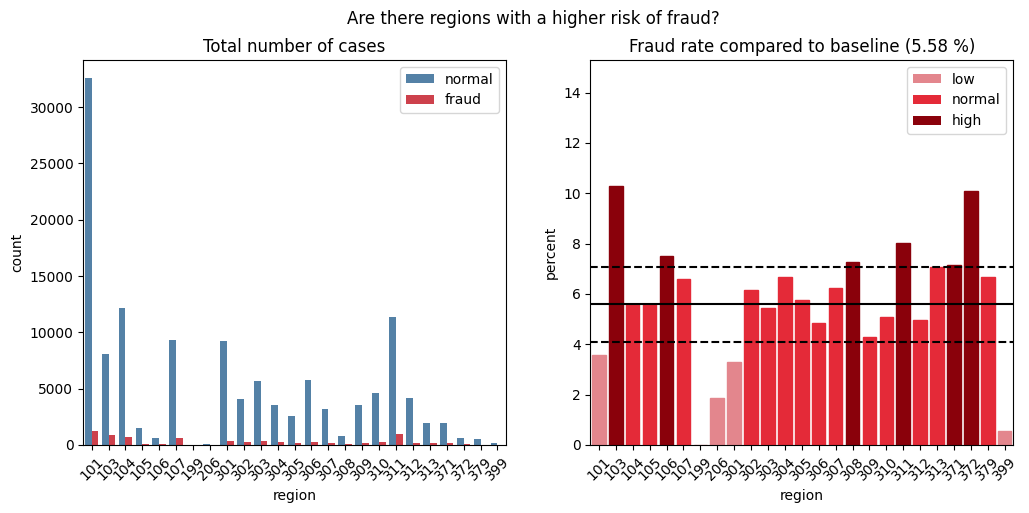

The feature region has 25 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: ['101', '301', '206', '399', '199']
normal: ['313', '379', '304', '107', '307', '302', '305', '104', '105', '303', '310', '312', '306', '309']
high: ['103', '372', '311', '106', '308', '371']


In [66]:
# 1. Plotting 
grouped_df_region, risk_categories_region = subplopts_fraud_per_category(df_client, 
                                                                         feature='region', 
                                                                         fraud_baseline=FRAUD_BASELINE, 
                                                                         fraud_range=FRAUD_RANGE, 
                                                                         verbose=True)

Comment:
-   in the plot on the right we can see that some regions have a fraud rate lower, similar or higher than baseline (different shades of red)
-   this can be used to create a new freature where these regions are assigned to the three different fraud risk categories (low, normal, high)

In [67]:
# 2. Create new feature
df_client = create_fraud_risk_feature(df_client, 
                                      feature_in='region', 
                                      new_categories=risk_categories_region, 
                                      verbose=True)
df_client.head(2)


New feature "risk_region" was added to the dataframe.
Higher values indicate a higher risk of fraud.

 Category 0: 32.14%
 Category 1: 48.95%
 Category 2: 18.91%


,district,client_id,client_category,region,creation_date,target,risk_region
0,60,0,11,101,1994-12-31,0,0
1,69,1,11,107,2002-05-29,0,1


In [68]:
# 3. Save feature names for modelling

CAT_FEATURES = add_feature_to_list('risk_region', CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

Categorical features:
['risk_region']

Numerical features:
[]


### Feature `district`

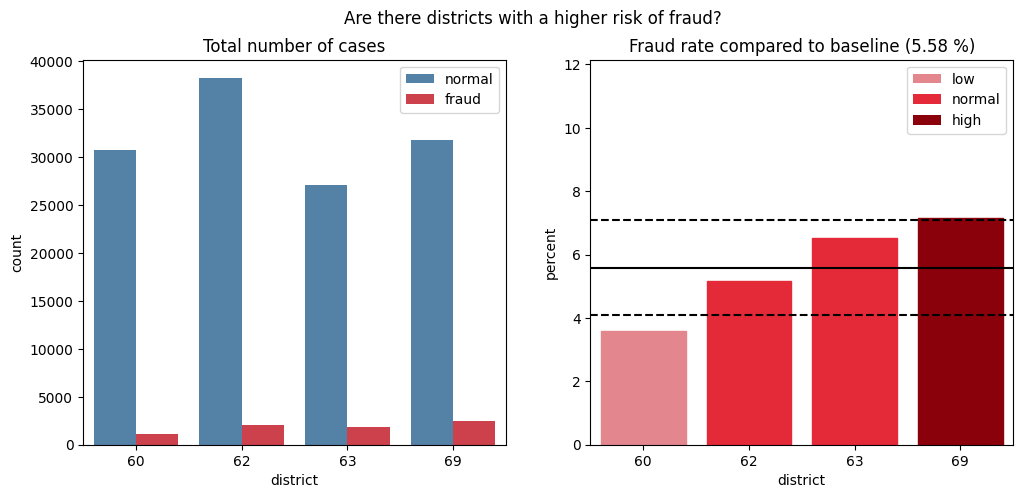

The feature district has 4 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: ['60']
normal: ['63', '62']
high: ['69']


In [69]:
# 1. Plotting
grouped_df_district, risk_categories_district  = subplopts_fraud_per_category(df_client, 
                                                                              feature='district', 
                                                                              fraud_baseline=FRAUD_BASELINE, 
                                                                              fraud_range=FRAUD_RANGE, 
                                                                              verbose=True)

Comment:
*   the fraud rate seems to be a little higher than baseline range in district 69 and lower in discrict 60
*   aggregate the districts to a new feature `risk_district` with 3 levels low, normal, high (as above) 

In [70]:
# 2. Create new feature
df_client = create_fraud_risk_feature(df_client, 
                                      feature_in='district', 
                                      new_categories=risk_categories_district, 
                                      verbose=True)
df_client.head(2)


New feature "risk_district" was added to the dataframe.
Higher values indicate a higher risk of fraud.

 Category 0: 23.56%
 Category 1: 51.18%
 Category 2: 25.26%


,district,client_id,client_category,region,creation_date,target,risk_region,risk_district
0,60,0,11,101,1994-12-31,0,0,0
1,69,1,11,107,2002-05-29,0,1,2


In [71]:
# 3. Save feature names for modelling

CAT_FEATURES = add_feature_to_list('risk_district', CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

Categorical features:
['risk_region', 'risk_district']

Numerical features:
[]


### Feature `client_category`

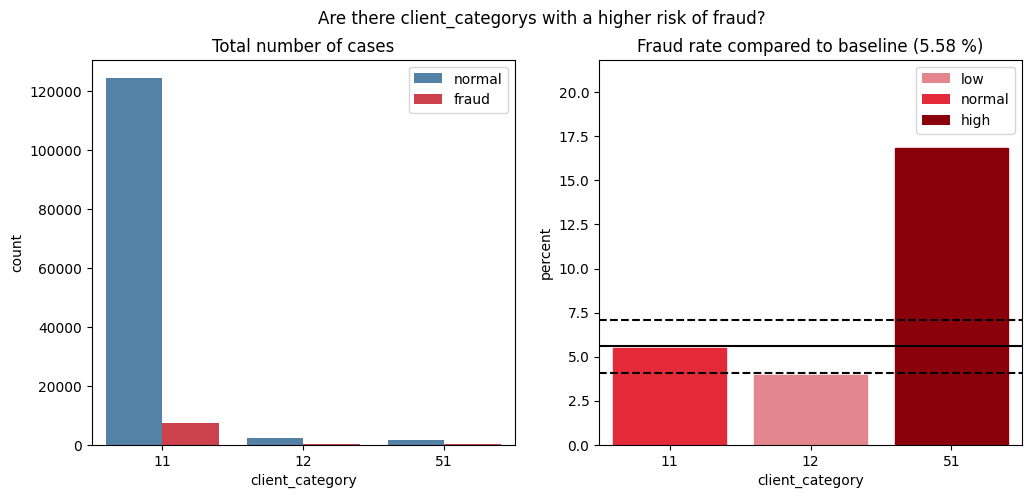

The feature client_category has 3 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: ['12']
normal: ['11']
high: ['51']


In [72]:
# 1. Plotting
grouped_df_client_cat, risk_categories_client_cat  = subplopts_fraud_per_category(df_client, 
                                                                                  feature='client_category', 
                                                                                  fraud_baseline=FRAUD_BASELINE, 
                                                                                  fraud_range=FRAUD_RANGE, 
                                                                                  verbose=True)
 

Comment: 
*   The fraud rate for client category 51 is 3 times higher than baseline
*   but category  51 represents only a small proportion of the data
*   As the original feature has 3 categories too , creating a new  risk feature with 3 levels does not change anything
*   for a better comparability it is done anyway 

In [73]:
# 2. Create new feature
df_client = create_fraud_risk_feature(df_client, 
                                      feature_in='client_category', 
                                      new_categories=risk_categories_client_cat, 
                                      verbose=True)
df_client.head(2)


New feature "risk_client_category" was added to the dataframe.
Higher values indicate a higher risk of fraud.

 Category 0: 1.71%
 Category 1: 97.05%
 Category 2: 1.24%


,district,client_id,client_category,region,creation_date,target,risk_region,risk_district,risk_client_category
0,60,0,11,101,1994-12-31,0,0,0,1
1,69,1,11,107,2002-05-29,0,1,2,1


In [74]:
# 3. Save feature names for modelling

CAT_FEATURES = add_feature_to_list('risk_client_category', CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

Categorical features:
['risk_region', 'risk_district', 'risk_client_category']

Numerical features:
[]


### Account creation date features
* using the account creation date from the column `creation_date` to extract the features year, month, weekday
* Is the fraud rate related to account creation year, month or weekday?
* analyse these features following the same workflow as for categorical variables

In [75]:
if 'creation_date' in df_client.columns.to_list():

     # create new columns for account creation by years, months and weekdays  
    df_client['acc_creation_year'] = df_client.creation_date.dt.year
    df_client['acc_creation_month'] = df_client.creation_date.dt.month
    df_client['acc_creation_weekday'] = df_client.creation_date.dt.dayofweek
    
    # drop initial column
    df_client.drop('creation_date', axis=1, inplace=True)

df_client.head(2)

,district,client_id,client_category,region,target,risk_region,risk_district,risk_client_category,acc_creation_year,acc_creation_month,acc_creation_weekday
0,60,0,11,101,0,0,0,1,1994,12,5
1,69,1,11,107,0,1,2,1,2002,5,2


In [76]:
# check dtypes
df_client[['acc_creation_year','acc_creation_month', 'acc_creation_weekday']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   acc_creation_year     135493 non-null  int32
 1   acc_creation_month    135493 non-null  int32
 2   acc_creation_weekday  135493 non-null  int32
dtypes: int32(3)
memory usage: 1.6 MB


In [77]:
# TODO: dtype conversions account creation features 

#### Feature `acc_creation_year`

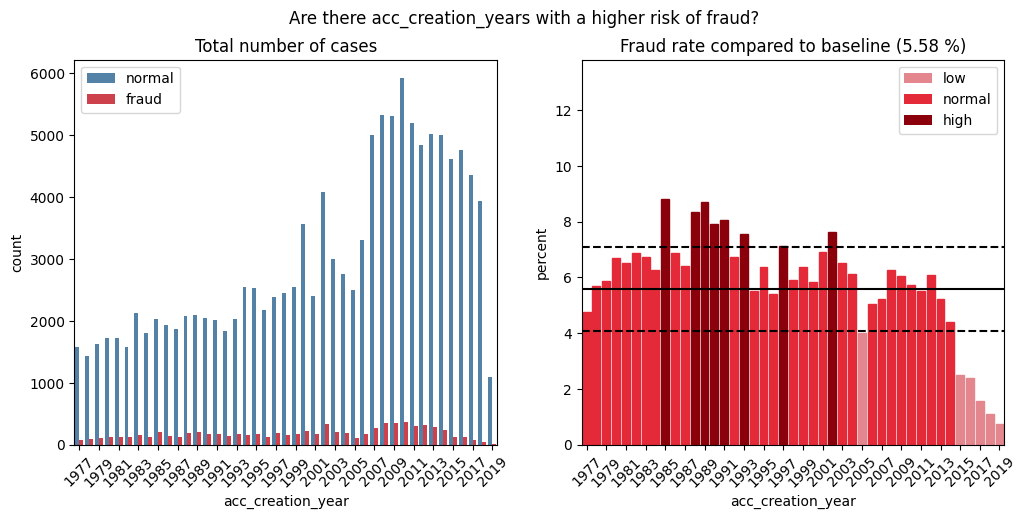

The feature acc_creation_year has 43 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: [2005, 2015, 2016, 2017, 2018, 2019]
normal: [2001, 1982, 1986, 1983, 1992, 1980, 2003, 1981, 1987, 1999, 1995, 2008, 1984, 2004, 2012, 2009, 1998, 1979, 2000, 2010, 1978, 2011, 1994, 1996, 2007, 2013, 2006, 1977, 2014]
high: [1985, 1989, 1988, 1991, 1990, 2002, 1993, 1997]


In [78]:
# 1. Plotting
grouped_df_acc_creation_year, risk_categories_acc_creation_year  = subplopts_fraud_per_category(df_client, 
                                                                                                feature='acc_creation_year', 
                                                                                                fraud_baseline=FRAUD_BASELINE, 
                                                                                                fraud_range=FRAUD_RANGE, 
                                                                                                verbose=True)

Comment:
*   the fraud rate seems to be lowest in the most recent accounts (since 2015)
*   accouts created during the 80s show a slighly higher fraud rate than baseline
*   aggregate the account creation years to a new risk fearture with 3 levels  (low, normal, high) as seen above

In [79]:
# 2. Create new feature
df_client = create_fraud_risk_feature(df_client, 
                                      feature_in='acc_creation_year', 
                                      new_categories=risk_categories_acc_creation_year, 
                                      verbose=True)
df_client.head(2)


New feature "risk_acc_creation_year" was added to the dataframe.
Higher values indicate a higher risk of fraud.

 Category 0: 16.0%
 Category 1: 68.98%
 Category 2: 15.01%


,district,client_id,client_category,region,target,risk_region,risk_district,risk_client_category,acc_creation_year,acc_creation_month,acc_creation_weekday,risk_acc_creation_year
0,60,0,11,101,0,0,0,1,1994,12,5,1
1,69,1,11,107,0,1,2,1,2002,5,2,2


#### Feature `acc_creation_month`

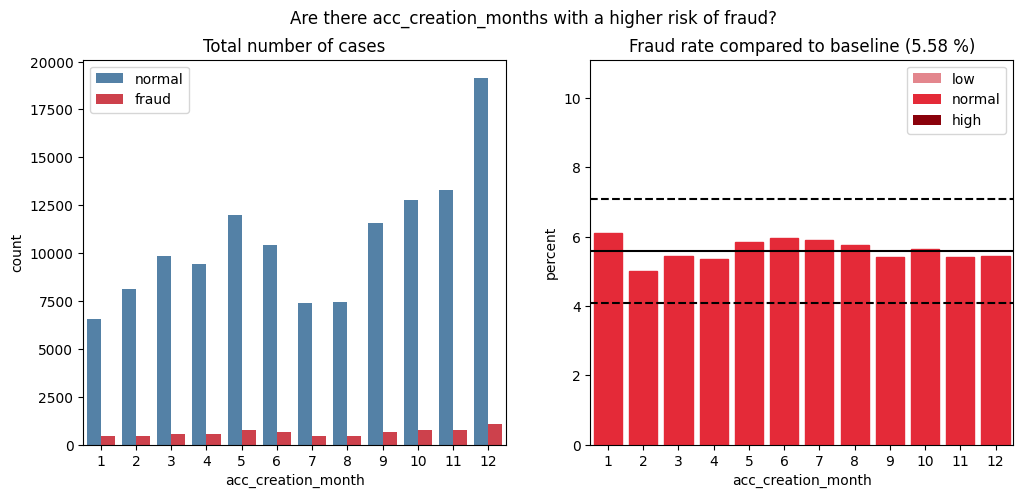

The feature acc_creation_month has 12 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: []
normal: [1, 6, 7, 5, 8, 10, 3, 12, 11, 9, 4, 2]
high: []


In [80]:
# 1. Plotting
grouped_df_acc_creation_month, risk_categories_acc_creation_month  = subplopts_fraud_per_category(df_client, 
                                                                                                  feature='acc_creation_month', 
                                                                                                  fraud_baseline=FRAUD_BASELINE, 
                                                                                                  fraud_range=FRAUD_RANGE, 
                                                                                                  verbose=True)

Comment:
*   the month account creation does not seem to be related to fraud
*   no risk feature is created
*   feature will not be included in the analysis

#### Feature `acc_creation_weekday`

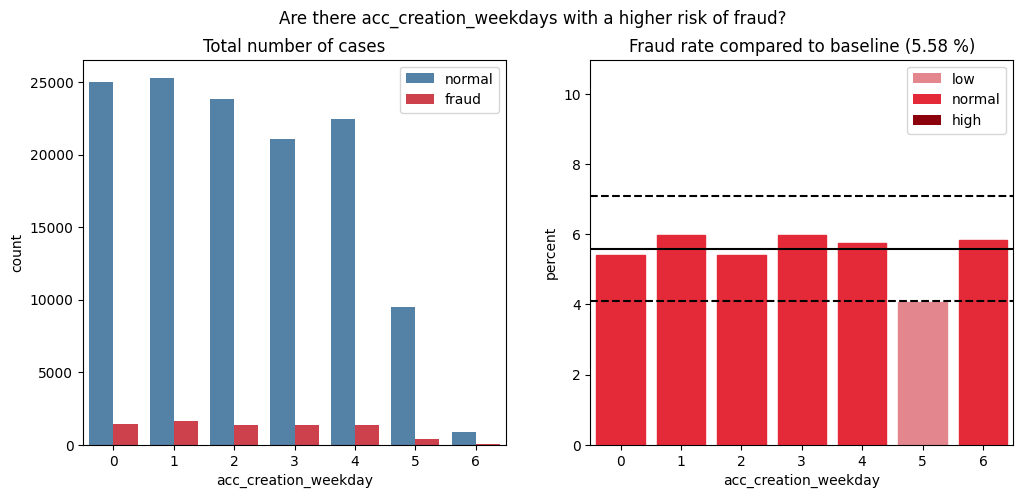

The feature acc_creation_weekday has 7 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: [5]
normal: [3, 1, 6, 4, 0, 2]
high: []


In [81]:
# 1. Plotting
grouped_df_acc_creation_weekday, risk_categories_acc_creation_weekday  = subplopts_fraud_per_category(df_client, 
                                                                                                      feature='acc_creation_weekday', 
                                                                                                      fraud_baseline=FRAUD_BASELINE, 
                                                                                                      fraud_range=FRAUD_RANGE, 
                                                                                                      verbose=True)

Comment:
* accounts created on saturdays show a slighly smaller fraud rate than baseline range
* create fraud risk feature with only 2 levels (low and normal)

In [82]:
# 2. Create new feature
df_client = create_fraud_risk_feature(df_client, 
                                      feature_in='acc_creation_weekday', 
                                      new_categories=risk_categories_acc_creation_weekday, 
                                      verbose=True)
df_client.head(2)


New feature "risk_acc_creation_weekday" was added to the dataframe.
Higher values indicate a higher risk of fraud.

 Category 0: 7.3%
 Category 1: 92.7%


,district,client_id,client_category,region,target,risk_region,risk_district,risk_client_category,acc_creation_year,acc_creation_month,acc_creation_weekday,risk_acc_creation_year,risk_acc_creation_weekday
0,60,0,11,101,0,0,0,1,1994,12,5,1,0
1,69,1,11,107,0,1,2,1,2002,5,2,2,1


In [83]:
# 3. save feature names for modelling
account_creation_features = ['risk_acc_creation_year', 
                             'risk_acc_creation_weekday']

CAT_FEATURES = add_feature_to_list(account_creation_features, CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

Categorical features:
['risk_region', 'risk_district', 'risk_client_category', 'risk_acc_creation_year', 'risk_acc_creation_weekday']

Numerical features:
[]


Interim Summary
*   From the analysis of the client data (`df_client`) several variables are selected for modelling (see `CAT_FEATURES`)
*   from the categorical features of the client data (region, district, client_category) new features were created that reflect the risk (low, normal, high) of fraud for each category
*   similar procedure for extracted datetime features (account creation year, month, weekday)

## Explore invoice data

In the invoice data the client's total engery consumption is given in one column for each level 1 to 4.


### Invoice date features
*   from the client's invoice date data (`invoice_date`) create datetime features for year, month, weekday and day of the invoice for further analyses



In [84]:
df_invoice['invoice_year'] = df_invoice.invoice_date.dt.year
df_invoice['invoice_month'] = df_invoice.invoice_date.dt.month
df_invoice['invoice_weekday'] = df_invoice.invoice_date.dt.dayofweek
df_invoice['invoice_day'] = df_invoice.invoice_date.dt.day
df_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_status,counter_code,remark,counter_coeff,consumption_lvl_1,consumption_lvl_2,consumption_lvl_3,consumption_lvl_4,old_index,new_index,months_number,counter_type,invoice_year,invoice_month,invoice_weekday,invoice_day
0,0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,2014,3,0,24
1,0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,2013,3,4,29
2,0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,2015,3,0,23
3,0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,2015,7,0,13
4,0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,2016,11,3,17


### Feature `counter_type`

*   To investigate gas and electricity consumption separately, create two data frames, one for each `counter_type`

* Indicates gas versus vs. electricity consumption
    *   create seperate dfs for a more detailed analysis
    *   create  `df_elec` for electricity for `counter_type =='ELEC'`
    *   create  `df_gas` for gas for `counter_type =='GAZ'`

In [85]:
# 1) analyse electricity and gas comsumption separately
df_elec = df_invoice[df_invoice.counter_type == 'ELEC']
df_gas = df_invoice[df_invoice.counter_type == 'GAZ']

# 2) add the new aggregated features of the invoice data to df_merged
df_merged = df_client

# 3) analyse newly created features grouped by target (fraud/no fraud)

### Feature `account_duration`
1) from the invoice date extract the account duration (in days) for gas and electricity accounts resprectively 

In [86]:
# from the invoice data extract the duration for gas and electricity accounts 
# use the function extract_account_duration() from Scripts/preprocessing.py
elec_acc_dur = extract_account_duration(df_elec, prefix='elec')
gas_acc_dur = extract_account_duration(df_gas, prefix='gas')

# merge gas and elec durations
features_account_dur = pd.merge(elec_acc_dur, gas_acc_dur, on='client_id', how='outer')

# replace missing values with 0 
features_account_dur = features_account_dur.replace({pd.NaT: "0 days" })

# calculate the difference between account lengths
features_account_dur['difference_acc_dur']= abs(features_account_dur.elec_acc_dur_days - features_account_dur.gas_acc_dur_days)

# convert the timedelta64[ns] feature to int64 by extracting the days 
features_account_dur['elec_acc_dur_days']= features_account_dur.elec_acc_dur_days.dt.days
features_account_dur['gas_acc_dur_days']= features_account_dur.gas_acc_dur_days.dt.days
features_account_dur['difference_acc_dur']= features_account_dur.difference_acc_dur.dt.days
features_account_dur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   client_id           135493 non-null  category
 1   elec_acc_dur_days   135493 non-null  int64   
 2   gas_acc_dur_days    135493 non-null  int64   
 3   difference_acc_dur  135493 non-null  int64   
dtypes: category(1), int64(3)
memory usage: 8.7 MB


In [87]:
features_account_dur.head()

,client_id,elec_acc_dur_days,gas_acc_dur_days,difference_acc_dur
0,0,4901,0,4901
1,1,4913,0,4913
2,10,4921,0,4921
3,100,2664,0,2664
4,1000,1585,0,1585


In [88]:
features_account_dur.isna().sum()
# there are no more missing values

# 0 days reflects that the account does not exist (for duration), 
# or that both accounts exist for the same amount of time (for difference)


client_id             0
elec_acc_dur_days     0
gas_acc_dur_days      0
difference_acc_dur    0
dtype: int64

2)  Check whether the difference in account durations differs between fraudulent or normal energy consumption

In [89]:
# first: add new features to df_merged 
df_merged = pd.merge(df_merged, features_account_dur, on='client_id', how='outer')



In [90]:
# quickly compare means by grouping
account_dur_grouped = df_merged.groupby('target', observed=False, as_index=False)[['elec_acc_dur_days', 'gas_acc_dur_days', 'difference_acc_dur']]
account_dur_grouped.mean()

,target,elec_acc_dur_days,gas_acc_dur_days,difference_acc_dur
0,0,2943.064975,1360.950730,1615.527004
1,1,3968.148824,2023.428099,1977.699577


In [91]:
# get a more detailed overview with describe()
account_dur_grouped.describe()

target elec_acc_dur_days                                                  
                     count         mean          std  min     25%     50%   
0      0          127927.0  2943.064975  1857.974596  0.0  1113.0  3242.0  \
1      1            7566.0  3968.148824  1340.980892  0.0  3165.0  4684.5   

                  gas_acc_dur_days  ...                 difference_acc_dur   
      75%     max            count  ...     75%     max              count   
0  4852.0  5442.0         127927.0  ...  2924.0  5417.0           127927.0  \
1  4978.0  5442.0           7566.0  ...  3851.5  5378.0             7566.0   

                                                                
          mean          std  min  25%     50%      75%     max  
0  1615.527004  1815.484821  0.0  0.0   809.0  2920.00  5442.0  
1  1977.699577  1990.927780  0.0  0.0  1339.0  4203.25  5441.0  

[2 rows x 25 columns]

Comment:
*   it seems that fraudulent energy consumption is associated with longer account durations
*   also a larger difference between electricity and gas account duration seems to be related to fraud
*   create some boxplots to depict this more clearly

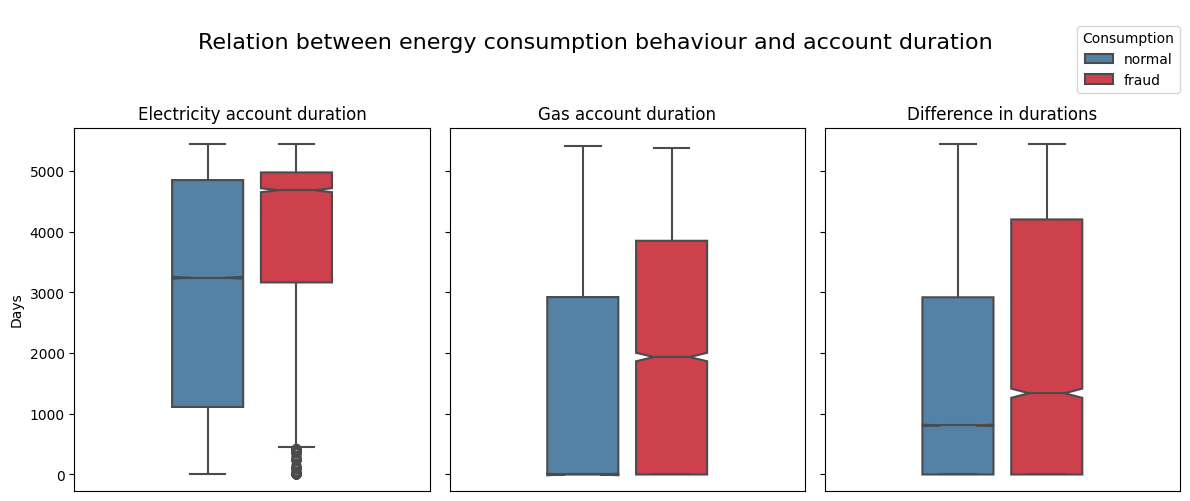

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(12,5), gridspec_kw={'width_ratios': [1, 1, 1]}, sharey=True)
fig.suptitle(f'\nRelation between energy consumption behaviour and account duration', fontsize=16, verticalalignment='center')

features = ['elec_acc_dur_days', 'gas_acc_dur_days', 'difference_acc_dur']
y_labels = ['Electricity account duration','Gas account duration' , 'Difference in durations']

for subplot in range(0,3):
    sns.boxplot(ax=axes[subplot], 
                data=df_merged, 
                y=features[subplot], 
                # x='target',    # required for grouping before searborn v0.13.0
                hue='target', 
                palette=[COLOR_1, RED_COLORS[1]], 
                gap=.2,         # useful feature added in seaborn v0.13.0
                width=.5, 
                linewidth=1.5, 
                notch=True
                )
    
    axes[subplot].set_title(y_labels[subplot])
    axes[subplot].set_ylabel('')                # remove yaxis label
    axes[subplot].legend([],[], frameon=False)  # remove legend
    axes[subplot].set_xticks([])                # remove xticks

    if subplot == 0:
        axes[subplot].set_ylabel('Days')
    else:
       axes[subplot].set_ylabel('') 

    if subplot == 2: # add custom legend to last subplot (and don't forget to change plt.tight_layout() accordingly!)
        legend_handles, _= axes[subplot].get_legend_handles_labels()
        axes[subplot].legend(legend_handles, ['normal', 'fraud'])
        sns.move_legend(axes[subplot], 
                        title='Consumption', 
                        bbox_to_anchor=(1.02, 1.3), 
                        loc='upper right')  # remove label title
    
plt.tight_layout(rect=[0, 0.03, 1, 1.15]) 
    # tight_layout only considers ticklabels, axis labels, and titles
    # adjustment with [left bottom, right, top] in normalized (0,1) space
    # increase top value to reduce space between top figures and suptitle (that is created when customizing the legend)
plt.show()


Interpretation of a boxplot:
*   you can see the informationfrom the `describe()` function at one glance
*   the median marks the mid point of the values (horizontal line with notches in box) 
*   the ends of the boxes and the median divide the values in 4 quartiles, that means that 25 % of the values are 
    *   below the lower box bound
    *   between lower box bound and the median
    *   between the median and the upper box bound, and 
    *   above the upper box bound
*   50% of the values of a condition are within the boxes (Interquartile  range, IQR)
*   the min and max score (excluding outliers) are depicted by the whiskers, indicating the range of values
*   outliers are values 1.5 * IQR above or below the box
*   dispersion of the values in a condition is indicated by length of box, whiskers and outliers

Comment: 
*   for fraudulent activitiy (red) the median is higher than for normal activity (blue) in all 3 duration features
*   this means fraud could be more likely in longer account duratios and larger differences between account durations

In [93]:
#  Select feature names for modelling
NUM_FEATURES = add_feature_to_list('difference_acc_dur', NUM_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

Categorical features:
['risk_region', 'risk_district', 'risk_client_category', 'risk_acc_creation_year', 'risk_acc_creation_weekday']

Numerical features:
['difference_acc_dur']


In [94]:
# TODO: idea: check whether the regularity of invoices is related to fraud 
# TODO: check wheter the difference between old index and new index equals the consumption 

### Feature energy consumption 

Workflow
*   from client's electricity and gas invoices compute general and monthly consumption per level 
    *   for the new features compute mean, std and max-min range
*   add the features to df_merged
*   plot features grouped by target 


In [95]:
# create custom function with name in namespace
# TODO: add docstring
def max_min_range(x):
    return x.max() - x.min()

max_min_range.__name__ = 'max_min_range'

# example
# df.groupby('group', observed=True).agg({'a':['sum', 'max'], 
#                         'b':'mean', 
#                         'c':'sum', 
#                         'd': max_min_range})

In [96]:
def calculate_energy_consumption(data: pd.DataFrame, consumption_type: str, level: int, monthly=bool):
    # comnbines genearl and monthly aggregation of consumption in one function (depending on bool 'monthly')
    operations = ['mean', 'std', max_min_range]
    aggregations = {}
    aggregations[f'consumption_lvl_{level}'] = operations

    if monthly:
        agg_data = data.groupby(['client_id','invoice_month'], observed=False, dropna=False).agg(aggregations)
        # reshape df
        #agg_data = agg_data.stack(level=0, future_stack=True).reset_index()
        agg_data = agg_data.stack(level=0).reset_index()
        agg_data.drop(['level_2'], axis=1, inplace=True)
        agg_data = agg_data.pivot(index='client_id', columns=['invoice_month'])
        # reduce multiindex using map and reset index
        agg_data.columns = agg_data.columns.map(lambda s: '_'.join(map(str, s)))
        agg_data = agg_data.reset_index()
        # rename columns
        agg_data.set_index('client_id', inplace=True)
        agg_data.columns = [f'{consumption_type}_{level}_mon_{column.split("_")[1]}_{column.split("_")[0]}' 
                            if len(column.split("_")) == 2 
                            else f'{consumption_type}_{level}_mon_{column.split("_")[3]}_{column.split("_")[0]}_{column.split("_")[1]}_{column.split("_")[2]}'
                            for column in agg_data.columns
                            ]
        agg_data = agg_data.reset_index()

    else: 
        agg_data = data.groupby(['client_id'], observed=False, dropna=False).agg(aggregations)
        # reshape df
        #agg_data= agg_data.stack(level=0, future_stack=True).reset_index()
        agg_data= agg_data.stack(level=0).reset_index()
        agg_data.drop(['level_1'], axis=1, inplace=True)
        # rename colums
        for operation in operations:
            if callable(operation): # get the operation name as str
                operation = operation.__name__
            agg_data.rename(columns={f'{operation}': f'{consumption_type}_{level}_{operation}'}, inplace=True)
       
    return agg_data

# (wrapper) functions used to calculate and add new features to the df

def columns_exist(target_df, test_df):
    # returns true if all colums of the test df exist already in the target df, otherwise false
    target_list = list(target_df.columns)
    test_list = list(test_df.columns)
    return all( element in target_list for element in test_list)


def add_consumption_features(to_df: pd.DataFrame, data: pd.DataFrame, consumption_type: str, monthly: bool):
    # add aggregated levelwise and monthly or general consumption featuress to df_merged,  (only if they do not already exist, otherwise update)
    for level in range(1,5):
        aggregated_features = calculate_energy_consumption(data, consumption_type, level, monthly) 
        if not columns_exist(to_df, aggregated_features):
            # add features
            to_df = pd.merge(to_df, aggregated_features, on='client_id', how='outer')
        else:
            # update existing features in to_df 
            to_df.update(aggregated_features)

    return to_df

In [97]:
# 2) add consumption features to df merged for plotting the features grouped by target

for montly_aggregation in [False, True]:
    for counter_type in ['elec', 'gas']:
        # for subsetting the invoice data 
        if counter_type == 'elec':
            counter_type_col = counter_type.upper()
        elif counter_type =='gas':
            counter_type_col = 'GAZ'
            
        df_merged = add_consumption_features(df_merged, df_invoice[df_invoice['counter_type']== counter_type_col], consumption_type=counter_type, monthly=montly_aggregation)
        

In [98]:
# show larger (scollable) output for all columns
pd.options.display.max_seq_items = 2000
df_merged.columns

# find out what is observed = true/False when using group by 
# observed=False includes all categories, also when not observed!!

Index(['district', 'client_id', 'client_category', 'region', 'target',
       'risk_region', 'risk_district', 'risk_client_category',
       'acc_creation_year', 'acc_creation_month', 'acc_creation_weekday',
       'risk_acc_creation_year', 'risk_acc_creation_weekday',
       'elec_acc_dur_days', 'gas_acc_dur_days', 'difference_acc_dur',
       'elec_1_mean', 'elec_1_std', 'elec_1_max_min_range', 'elec_2_mean',
       'elec_2_std', 'elec_2_max_min_range', 'elec_3_mean', 'elec_3_std',
       'elec_3_max_min_range', 'elec_4_mean', 'elec_4_std',
       'elec_4_max_min_range', 'gas_1_mean', 'gas_1_std',
       'gas_1_max_min_range', 'gas_2_mean', 'gas_2_std', 'gas_2_max_min_range',
       'gas_3_mean', 'gas_3_std', 'gas_3_max_min_range', 'gas_4_mean',
       'gas_4_std', 'gas_4_max_min_range', 'elec_1_mon_1_mean',
       'elec_1_mon_2_mean', 'elec_1_mon_3_mean', 'elec_1_mon_4_mean',
       'elec_1_mon_5_mean', 'elec_1_mon_6_mean', 'elec_1_mon_7_mean',
       'elec_1_mon_8_mean', 'elec_1_mo

#### Plots - Consumption per level

*   Using boxplots visually explore mean energy consumption 
    *   for electricity and gas
    *   grouped by target (0: no fraud,  1: fraud) and level (1-4)
*   level 1-4 determines the price of kWh depending on consumption 

<Axes: ylabel='elec_1_mean'>

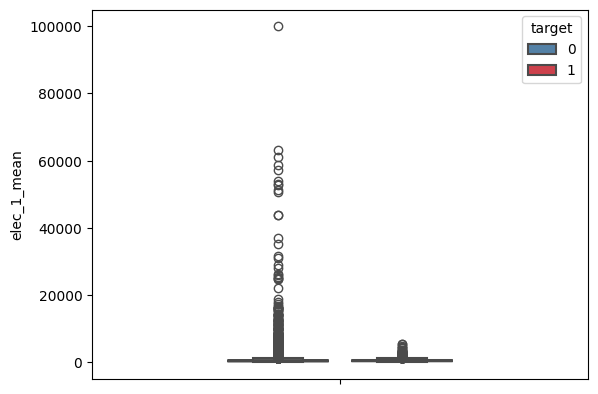

In [99]:
# Example: quick and dirty look at mean electric for level 1
sns.boxplot(data=df_merged, y='elec_1_mean', 
                hue='target', palette=[COLOR_1, RED_COLORS[1]], 
                gap=0.2, width=.5, linewidth=1.5, notch=True,)

Comment:
* There are large outliers, the boxes of the boxplot are not even visible

Next:
* Remove outliers from the plot to get a better overview

<Axes: ylabel='elec_1_mean'>

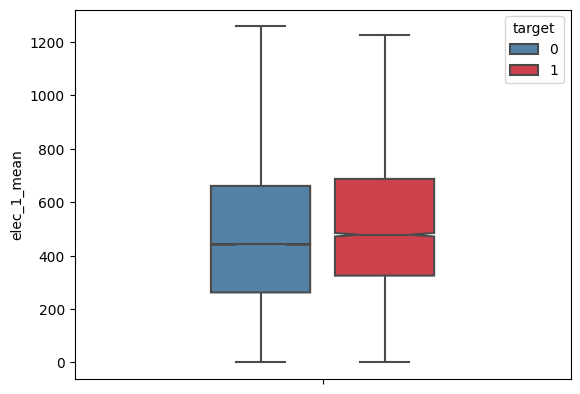

In [100]:
# Example: quick and dirty look at mean electric for level 1 (without outliers)
sns.boxplot(data=df_merged, y='elec_1_mean', 
                hue='target', palette=[COLOR_1, RED_COLORS[1]], 
                gap=0.2, width=.5, linewidth=1.5, notch=True,
                showfliers=False)   # remove the outliers for plotting 

Comment:
* When the outliers are removed from the plot, the boxes are visible and appear similar for both conditions (0: no fraud, 1: fraud) indicated by the close median and whisker lengths 
* For further analyses (and esp modelling) it could be important to remove the outliers (because they greatly affect the mean and predictions can become less reliable)

Next:
* Check energy consumption for all levels (using the function `boxplot_consumption_per_level()` from Scripts/plotting.py)

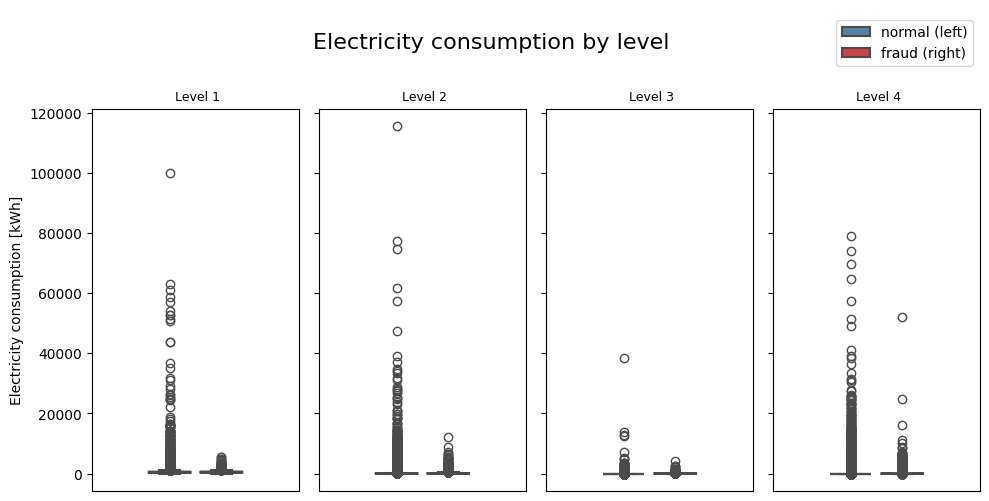

In [102]:
boxplot_consumption_per_level(df_merged, energy_type='elec', feature='mean', show_outliers=True)

Comment:
*   Across all consumption levels and conditions there are large outliers, while the majority of values seems to be much smaller

Next:
*   Supress display of outliers

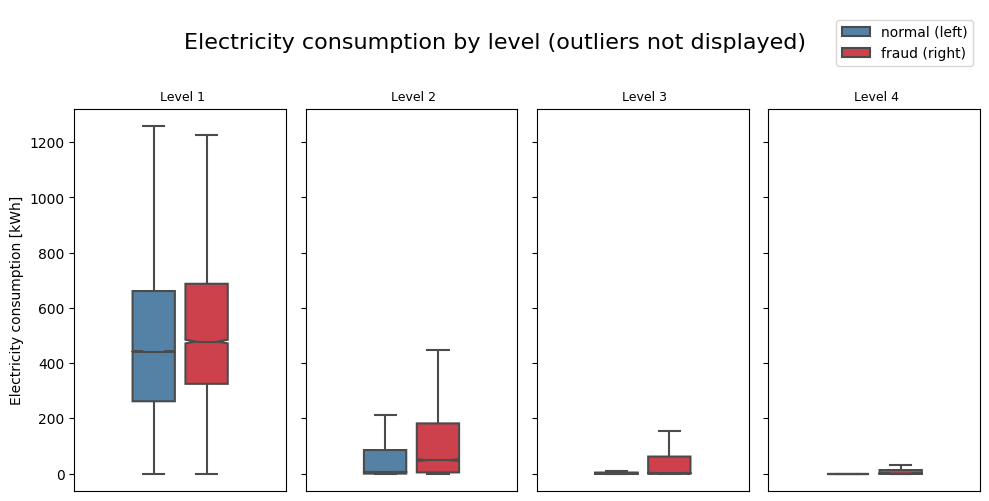

In [103]:
boxplot_consumption_per_level(df_merged, energy_type='elec', feature='mean', show_outliers=False)

Comment:
*   Without outliers the boxes become visible
*   The mean electricity consumption seems to be a similar for normal and fraudulent activity at level 1 (as seen before)
*   For level 2 to 4 the mean electricity consumption seems to be higher in fraudulent consumption   
*   This difference could be relevant for modelling 

Next: 

* Taking a look at gas comsumption

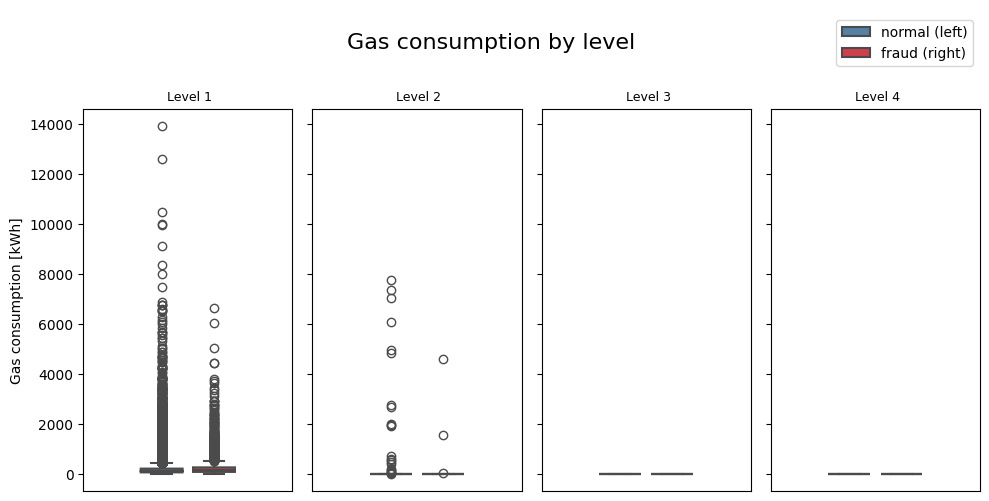

In [104]:
boxplot_consumption_per_level(df_merged, energy_type='gas', feature='mean', show_outliers=True)

Comment:
*  For level 3 and 4 there seems to be no / or only minimal gas consumption
*  Similar to electricity consumption, there are large outliers in the mean gas consumption for level 1 and 2 
*  The boxes of boxplots barely visible 

Next:
*   Let's c how the plot looks without outliers

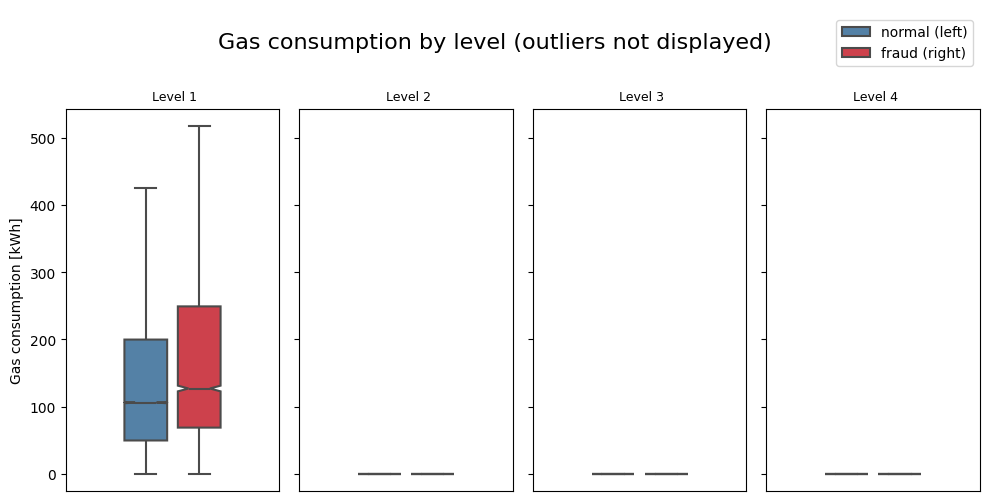

In [105]:
boxplot_consumption_per_level(df_merged, energy_type='gas', feature='mean', show_outliers=False)

Comment:
*   When outliers are not displayed it becomes apparent that the mean level 1 gas consumption seems to be higher in fraudulent activity (you cannot see this in the plots above)
*   This emphazises again how important it might be to take care of the outliers 
*   For level 2-4 we cannot see any consumption

Next:
*   Explore different options to remove outliers
    *   How does it affect the distribution of values in a condition?
    *   How much % of the values are removed (per condition)?
    *   Are outliers driving the differences between fraud and no fraud conditions or are they evenly distributed across conditions? 

In [106]:
# TODO: explore different options to remove outliers

#### Outliers 

*   Explore different options toi remove outliers from consumption features 

Using boxplots:
*   count the number of outliers/values within boundries
*   calculate proportion of outliers to determine whether it is acceptable to remove them  

In [70]:
# to be continued ...

#### Plots  - Consumption per month & level

In [109]:
#  functions for plotting monthly consumption 
# TODO: docstring + migration to scripts dir

def aggregate_monthly_consumption(data: pd.DataFrame, consumption_type: str, level: int):
    # using stack
    operations = ['mean', 'std', max_min_range]
    aggregations= {}

    for month in range(1,13):
        aggregations[f'{consumption_type}_{level}_mon_{month}_mean'] = operations
        agg_data = data.groupby('target', observed=False).agg(aggregations)
   
    # change format for plotting 
    #agg_data = agg_data.stack(level=0, future_stack=True).reset_index()
    agg_data = agg_data.stack(level=0).reset_index()

    # rename months  
    agg_data.rename(columns={'level_1': 'months'}, inplace=True)
    #agg_data['months'] =[i[-2:].replace('_', '') for i in  agg_data['months']]
    agg_data['months'] = [i.split('_')[3] for i in agg_data['months'] ]

    # convert month dtype to ordered category
    agg_data['months'] = pd.Categorical(agg_data['months'],
                                       categories=['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12'], 
                                       ordered=True
                                       )

    return agg_data


def calculate_error_bar_bounds(y, error, limit=True):

    # y_data = data[data.target == 0]['mean']
    # error = data[data.target == 0]['std']
    upper = y + error
    lower = y - error 
    if limit: #  set negative values to zero for plotting
        lower.loc[lower <0 ] = 0 
    return lower, upper


def plot_monthly_consumption(data_df: pd.DataFrame, consumption_type: str, metric: str, error_metric='std'):
   
    ###  energy type has to be chosen

    # type = 'elec' or 'gas'
    if consumption_type == 'elec':
        consumption_label = 'electricity'
    elif consumption_type == 'gas':
        consumption_label = consumption_type
    else:
        return f'Type is not any of "elec" or "gas"'
    
    ### construct the plot 

    fig, axes = plt.subplots(2, 2, figsize=(8, 7), sharex=True, sharey=True)
    fig.suptitle(f'Monthly {consumption_label} consumption', fontsize=14, verticalalignment='center')

    axes_ref = ([0, 0], [0, 1], [1, 0], [1, 1]) # to address the axes of each subplot
    level_descriptions = ['< 2.400 kWh', 
                          '2.401 - 3.600 kWh', 
                          '3.401 - 6.000 kWh', 
                          '> 6.000 kWh',]

    for subplot in range(0,4):

        data = aggregate_monthly_consumption(data_df, consumption_type, level=subplot+1)

        sns.lineplot(ax=axes[axes_ref[subplot][0]][axes_ref[subplot][1]], 
                    data=data, x='months', y=metric, 
                    hue='target', palette=[COLOR_1, RED_COLORS[1]], 
                    linewidth=2,
                    )
        
        # change subplot titles/labels
        axes[axes_ref[subplot][0]][axes_ref[subplot][1]].set_title(f'Consumption level {subplot+1}', fontsize=9)
        if error_metric:
            axes[axes_ref[subplot][0]][axes_ref[subplot][1]].set_ylabel(f'{metric.title()} ({error_metric}) consumption [kWh]')
        else:
            axes[axes_ref[subplot][0]][axes_ref[subplot][1]].set_ylabel(f'{metric.title()} consumption [kWh]')
        axes[axes_ref[subplot][0]][axes_ref[subplot][1]].set_xlabel('Months')
    
        # remove legends
        axes[axes_ref[subplot][0]][axes_ref[subplot][1]].legend([],[], frameon=False)  

        # add custom legend (to specific subplot)
        if subplot == 1:                   
            legend_handles, _= axes[axes_ref[subplot][0]][axes_ref[subplot][1]].get_legend_handles_labels()
            axes[axes_ref[subplot][0]][axes_ref[subplot][1]].legend(legend_handles, ['normal', 'fraud'])
            sns.move_legend(axes[axes_ref[subplot][0]][axes_ref[subplot][1]], 
                            title='',       # remove legend title
                            bbox_to_anchor=(1.02, 1.29), 
                            loc='upper right')  
        
        ### Optional:  Add custom error bars for each group 

        if error_metric:    
            
            # calculate error bar bounds
            normal_error = calculate_error_bar_bounds(y=data[data.target == 0][metric],
                                                    error=data[data.target == 0][error_metric])
            fraud_error = calculate_error_bar_bounds(y=data[data.target == 1][metric], 
                                                    error=data[data.target == 1][error_metric])
            
            #x = data['months'].unique() # does not have the correct order
            x=['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12']

            #  fill space in between upper and lower error range
            axes[axes_ref[subplot][0]][axes_ref[subplot][1]].fill_between(x, normal_error[0], normal_error[1], color=COLOR_1, alpha=0.2)
            axes[axes_ref[subplot][0]][axes_ref[subplot][1]].fill_between(x, fraud_error[0], fraud_error[1], color=RED_COLORS[1], alpha=0.2)

    # layout 

    plt.tight_layout(rect=[0, 0.03, 1, 1.05]) 
    # tight_layout only considers ticklabels, axis labels, and titles
    # adjustment with [left bottom, right, top] in normalize (0,1) space
    # increase top to reduce space between top figures and suptitle (that is created when customizing the legend)
    
    plt.show()
    return

##### Electricity

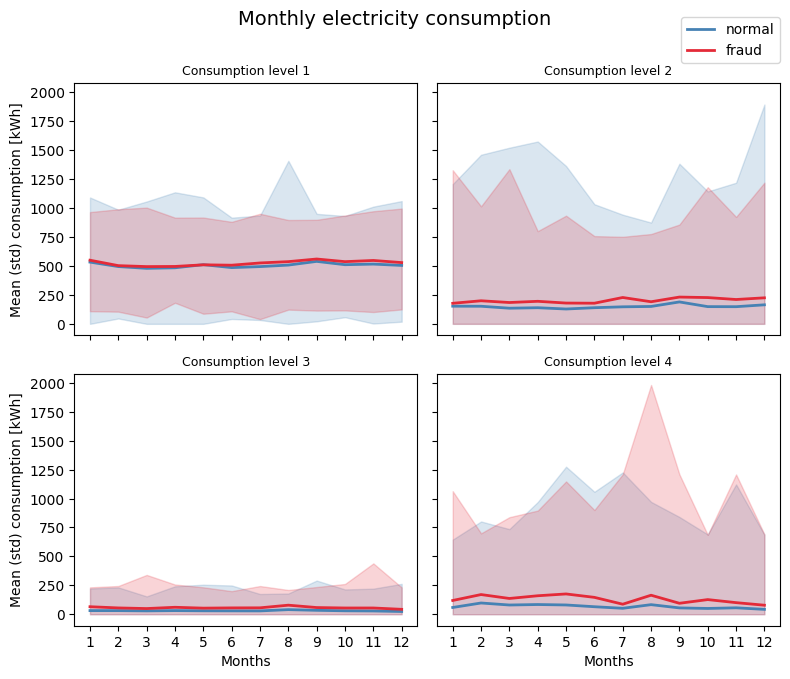

In [110]:
plot_monthly_consumption(df_merged, consumption_type='elec', metric='mean', error_metric='std')

Comment:
* with errorbars (std) the monthly energy consumption looks similar between normal and fraudulent activity (for each level)
* the mean consumption for fraudulent ativity seems to be slighly higher (across most months and levels), but the errorbars are huge
* removing outliers could improve this (because they affect the mean)

In [ ]:
plot_monthly_consumption(df_merged, consumption_type='elec', metric='mean', error_metric=None)

Comment:
* the same plot without error bars seems to indicate that the average monthly consumption for fraudulent activity <br> is a little higher than normal activity (for all levels)
* though probably not significantly (indicated by large standard variation seen in plot before)

In [ ]:
plot_monthly_consumption(df_merged, consumption_type='elec', metric='max_min_range', error_metric=None)

Comment:
* Looking at the monthly range between max and min electricity consumption <br> it seems to be higher and more varied in normal compared to fraudulent activity
* this could be an interesting feature to include in the analysis

##### Gas

In [ ]:
plot_monthly_consumption(df_merged, consumption_type='gas', metric='mean', error_metric='std')

Comment:
* at first glance we see that there is no gas consumption at level 3 and 4, these features can be discarded
* for level 1 gas consumption, the picture is similar to electricity: <br> slightly higher in fraudulent activity, but probably not significantly (large standard deviation indicated by the colored areas)
* there is only minimal consumption at level 2, but it could be included in the anallysis anyway

In [ ]:
plot_monthly_consumption(df_merged, consumption_type='gas', metric='mean', error_metric=None)

Comment:
* same conculsions in plot without error bars
* although at level 1 it is nice to see how similar the monthly consumption of gas is between fraud and normal activity (only at a different level)

In [ ]:
plot_monthly_consumption(df_merged, consumption_type='gas', metric='max_min_range', error_metric=None)

Comment:
* similar to the electricity consumption the min max range of gas consumptiuon indicates a higher level <br> and more variability in normal compared to fraudulent activity

In [ ]:
# select features  names for modelling

elec_names = [f'elec_{level}_mon_{month}_mean' for level in range(1, 5) for month in range(1, 13)]  # level 1-4
gas_names= [f'gas_{level}_mon_{month}_mean' for level in range(1, 3) for month in range(1, 13)]     # level 1-2

consumption_f_names = elec_names + gas_names # for now only include the mean monthly consumption features 

NUM_FEATURES = add_feature_to_list(consumption_f_names, NUM_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

### Feature `tarif_type`

*   reflects the counter_type
*   `tarif_type` >= 30 for gas consumption
*   `tarif_type` < 30  for electricity consumption

### Create mode and count feature of categorical variables

For further analyses  create mode and count features of categorical variables from the invoice data as there can be can have several categories per client (clientwise aggregation)

**Workflow**

---

1. Create mode and count feature using `create_mode_and_count_feature()` function
    *   mode: the most frequent category of a feature 
    *   count: how many different categories a client has per feature 


(2.) Calculate the proportion of mode feature categories (+ barplot) using `barplot_grouped_by_target()` function

(3). Recode mode feature and do type conversion (to str and category) using `recode_feature()` function
    *   categories that occur less frequently than a threshold (0.01%) are summarized into 'other' category 

4. Merge new features with `df_merged` for further analyses

**Further Analyses**

5. Plot and compare fraud rate in (MODE) feature categories to baseline fraud rate (5.58%) using `subplopts_fraud_per_category()` function 
    *   determine whether to establish a new fraud_risk feature (low, normal, high) depending on the distribution of categories
6. OPTIONAL: Create risk category feature from mode feature using `create_fraud_risk_feature()` function 

7. Plot and compare fraud rate in (COUNT) feature categories to baseline fraud rate (5.58%) using `subplopts_fraud_per_category()` function
    * keep the count as an numerical feature, but use this function to get an overview and decide whether to include it in modelling

---

*   categorical variables: can a fraud risk feature created with feature categories that indicate a higher/lower fraud rate?
*   numerical variables: is there a difference between normal and fraudulent energy consumprion?

#### Feature `elec_tarif_type` (mode/count)

In [ ]:
# 1. Create mode and count feature 
elec_tarif_type_features = create_mode_and_count_feature(df_elec,'tarif_type', 'elec_tarif_type')

# 4. merge new features with df_merged
df_merged = pd.merge(df_merged, elec_tarif_type_features, on='client_id', how='outer') 

In [ ]:
# 5. Plot and compare fraud rate in (MODE) feature categories to baseline 
grouped_df_e_tarif_type_mode, risk_categories_e_tarif_type_mode = subplopts_fraud_per_category(df_merged, 
                                                                                               'elec_tarif_type_mode',
                                                                                               fraud_baseline =FRAUD_BASELINE,
                                                                                               fraud_range=FRAUD_RANGE,
                                                                                               verbose=True)

Comment:
*   most clients have `elec_tarif_type_mode` category 11 with a 'normal' fraud rate (similar to baseline)
*   the fraud rate is lower than baseline in  `elec_tarif_type_mode` categories 9, other (21,24) and 'None'
*   'None' means that there is no electricity consumption for a client, only gas consumption
*   for the other tarif types the fraud rate is higher than baseline (but only few cases) 
*   aggregate the categories to a new risk feature with 3 levels (low, normal, high) as seen above

In [ ]:
# 6. create risk category feature from mode feature
df_merged = create_fraud_risk_feature(df_merged,
                                      'elec_tarif_type_mode', 
                                       risk_categories_e_tarif_type_mode,
                                       verbose=True)
df_merged.head(2)

In [ ]:
# 7. Plot and compare fraud rate in (COUNT) feature categories to baseline 
grouped_e_tarif_type_count, risk_categories_e_tarif_type_count = subplopts_fraud_per_category(df_merged, 
                                                                                              'elec_tarif_type_count',
                                                                                              fraud_baseline=FRAUD_BASELINE,
                                                                                              fraud_range=FRAUD_RANGE,
                                                                                              verbose=True)

Comment:
*   the fraud rate for clients with no electricity consumption (tyrif type count=0) and hence only gas consumption is low
*   the fraud rate for clients with only 1 electricity tarif type is normal (similar to baseline)
*   with more than 2 different electicity tarif types the fraud rate seems to be increased
*   the increase in fraud rate is extreme in clients with 5 different tarif types (~35 %) and with 6 different tarif types (65 %)
*   keep the count feature as numerical feature for modelling (for now)

In [42]:
# TODO: check other options to better represent the elec_tarif_type_count in the model 
# - polynominals ?

In [ ]:
# 8. features to keep for modeling 
CAT_FEATURES = add_feature_to_list('risk_elec_tarif_type_mode', CAT_FEATURES)
NUM_FEATURES = add_feature_to_list('elec_tarif_type_count', NUM_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

#### Feature `gas_tarif_type` (mode/count)

In [ ]:
# 1. Create mode and count feature 
gas_tarif_type_features = create_mode_and_count_feature(df_gas,'tarif_type', 'gas_tarif_type')
# 4. merge new features with df_merged
df_merged = pd.merge(df_merged, gas_tarif_type_features, on='client_id', how='outer')

In [ ]:
# 5. Plot and compare fraud rate in (MODE) feature categories to baseline 
grouped_gas_tarif_type_mode, risk_categories_gas_tarif_type_mode = subplopts_fraud_per_category(df_merged, 
                                                                                                'gas_tarif_type_mode',
                                                                                                fraud_baseline =FRAUD_BASELINE,
                                                                                                fraud_range=FRAUD_RANGE,
                                                                                                verbose=True)  

Comment: 
*   problem: what is "unlucky" here is when using a range of +/- 1.5 from baseline fraud rate to determine the normal risk category, tarif type 40 is a border case that in this example together with tarif type 45 is assigned to high risk, altough it is much closr to normal.
*   when the range is increased to 1.6 other features suffer a similar problem
*   idea: adapt threshold in function --> to arbitrary ?!
*   iterim solution: keep the mode feature with 4 categories and do not create a risk feature from it

In [ ]:
# 5. Plot and compare fraud rate in (COUNT) feature categories to baseline 
grouped_gas_tarif_type_count, risk_categories_gas_tarif_type_count = subplopts_fraud_per_category(df_merged, 
                                                                                                 'gas_tarif_type_count',
                                                                                                 fraud_baseline=FRAUD_BASELINE,
                                                                                                 fraud_range=FRAUD_RANGE,
                                                                                                 verbose=True)

Comment: 
*   the fraud rate increases with the number of gas tarif types
*   keep the numerical feature for modelling

In [ ]:
# 7. features to keep for modeling 
CAT_FEATURES = add_feature_to_list('gas_tarif_type_mode', CAT_FEATURES)
NUM_FEATURES = add_feature_to_list('gas_tarif_type_count', NUM_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

#### New Feature `energy_types`

*   Create a new categorical feature that contains info about energy types per client
    *   coding: 2 -->  a client has both (gas and elec) consumption
    *   coding: 1 -->  a client has only electricity consumption
    *   coding: 0 -->  a client has only gas consumption

In [48]:
# join tarif_type features in a new data frame 
df_invoice_features = pd.merge(elec_tarif_type_features, gas_tarif_type_features, on='client_id', how='outer') 

# masks to create coding for new column enery_types 
level_2 = (df_invoice_features['elec_tarif_type_count'] > 0) & (df_invoice_features['gas_tarif_type_count'] > 0)    # will be coded as 2
level_1 = (df_invoice_features['elec_tarif_type_count'] > 0) & (df_invoice_features['gas_tarif_type_count'] == 0)   # will be coded as 1
level_0 = (df_invoice_features['elec_tarif_type_count'] == 0) & (df_invoice_features['gas_tarif_type_count'] > 0)   # will be coded as 0

# assign categories 0,1,2, to new column energy_types, for the rows specified by the mask
for i in range(0,3):
    df_invoice_features.loc[eval(f'level_{i}'), 'energy_types'] = i

# recode features to int/str and category
for i_type in ['int','str', 'category']:
    df_invoice_features = convert_column_type(df_invoice_features, 'energy_types', i_type)

# add new feature to df_merged
df_merged = pd.merge(df_merged, df_invoice_features[['client_id', 'energy_types']], on='client_id', how='outer') 


In [ ]:
# quick check results  --> most clients have an electricity consumtion or both, only some consume only gas
print(df_invoice_features.energy_types.value_counts(normalize=True, dropna=False).reset_index())
df_invoice_features.sample(2)

In [ ]:
#  Plot and compare fraud rate in energy_types feature categories to baseline 
grouped_energy_types, risk_categories_energy_types = subplopts_fraud_per_category(df_merged, 
                                                                                  'energy_types',
                                                                                  fraud_baseline =FRAUD_BASELINE,
                                                                                  fraud_range=FRAUD_RANGE,
                                                                                  verbose=True)

Comment:
*   Clients that consume both types of energy seem to have the highest fraud rate.
*   The smallest fraud rate is in clients with gas only. 
*   the energy_types_risk feature is only created for illustration, but not added to the model 
*   the energy types feature will be added to the model (there are also 3 categories anyway)

In [ ]:
# 8: add features to keep for modeling 
CAT_FEATURES = add_feature_to_list('energy_types', CAT_FEATURES )

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

#### Feature `counter_status`

In [ ]:
# 1. create mode and count feature 
counter_status_features = create_mode_and_count_feature(df_invoice,'counter_status', 'counter_status', verbose=1)

# 4. merge with df_client
df_merged = pd.merge(df_merged, counter_status_features, on='client_id', how='outer') 

In [ ]:
# 5. MODE: plot feature grouped by category and target
grouped_ccounter_status_mode, risk_categories_counter_status_mode = subplopts_fraud_per_category(df_merged, 
                                                                                                'counter_status_mode',
                                                                                                fraud_baseline =FRAUD_BASELINE,
                                                                                                fraud_range=FRAUD_RANGE,
                                                                                                verbose=True)

Comment:
*   the counter status is the working status of the device that measures energy consumption
*   most clients counter status is 0 with a normal fraud rate close to baseline 
*   for the few clients with other counter status codes the fraud rate is low
*   create a  new fraud risk feature with 2 levels (low and normal) as seen above

In [ ]:
# 6. Create risk category feature 
df_merged = create_fraud_risk_feature(df_merged, 
                                      'counter_status_mode',
                                      risk_categories_counter_status_mode,
                                      verbose=True,)

In [ ]:
# 7. Plot and compare fraud rate in (COUNT) feature categories to baseline 
grouped_cs_count, risk_categories_counter_status_count = subplopts_fraud_per_category(df_merged, 
                                                                                     'counter_status_count',
                                                                                     fraud_baseline =FRAUD_BASELINE,
                                                                                     fraud_range=FRAUD_RANGE,
                                                                                     verbose=True)

Comment:
*   thew fraud rate is in normal range for clients with only 1 counter status 
*   the risk of fraud seems to increase with the number of different counter status codes
*   keep the numerical feature for modeling

In [ ]:
# 8: add features to keep for modeling 
CAT_FEATURES = add_feature_to_list('risk_counter_status_mode', CAT_FEATURES )
NUM_FEATURES = add_feature_to_list('counter_status_count', NUM_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

#### Feature `counter_code`

* is the registration number that identifies the measuring device (1-3 digits)

In [ ]:
# 1. create mode and count feature 
counter_code_features = create_mode_and_count_feature(df_invoice,'counter_code', 'counter_code', verbose=1)

# 4. merge with df_merged
df_merged = pd.merge(df_merged, counter_code_features, on='client_id', how='outer') 

In [ ]:
# 5. Plot and compare fraud rate in (MODE) feature categories to baseline 
grouped_c_code_mode, risk_categories_counter_code_mode = subplopts_fraud_per_category(df_merged, 
                                                                                     'counter_code_mode',
                                                                                     fraud_baseline=FRAUD_BASELINE,
                                                                                     fraud_range=FRAUD_RANGE,
                                                                                     verbose=True)

Comment:
*   There are 40 different counter codes 
*   several codes can be associated with fraud rates, lower, similar or higher than the baseline fraud rate
*   these are used to create a new counter_code_mode_risk feature (with 3 categories as above)
*   note: code 202 is a border case, because it is assigned to high risk category with a range of 1.5, but it is very close to normal range (keep in mind!)

In [ ]:
# 6. create risk category feature 
df_merged = create_fraud_risk_feature(df_merged, 
                                     'counter_code_mode',
                                      risk_categories_counter_code_mode,
                                      verbose=True)

df_merged.head(2)

In [ ]:
# 7. Plot and compare fraud rate in (COUNT) feature categories to baseline 
grouped_counter_code_count, risk_categories_counter_code_count = subplopts_fraud_per_category(df_merged, 
                                                                                             'counter_code_count',
                                                                                              fraud_baseline=FRAUD_BASELINE,
                                                                                              fraud_range=FRAUD_RANGE,
                                                                                              verbose=True)

Comment:
*   clients with only 1 counter code tend to have a lower fraud rate
*   clients with 2 counter codes have a 'normal' fraud rate
*   clients with more than 2 counter codes have a higher fraud rate
*   keep his numerical feature for modelling or create a categorical fraud risk feature of 
the count?
    *   a categorical feature seems to make sense with the cateories as above

In [ ]:
# 8. create risk category feature from the count feature
df_merged = create_fraud_risk_feature(df_merged, 
                                     'counter_code_count',
                                      risk_categories_counter_code_count,
                                      verbose=True)

In [ ]:
# 9: add features to keep for modeling 
CAT_FEATURES = add_feature_to_list(['risk_counter_status_mode', 'risk_counter_code_count'], CAT_FEATURES )

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

### Feature `counter_coefficient`

*   Coefficient used to convert the raw meter readings from the meter into actual consumption values

In [ ]:
# 1. create mode and count feature 
counter_coeff_features = create_mode_and_count_feature(df_invoice,'counter_coeff', 'counter_coeff', verbose=1)

# 4. merge with df_client
df_merged = pd.merge(df_merged, counter_coeff_features, on='client_id', how='outer')

In [66]:
# 4. merge with df_client
df_merged = pd.merge(df_merged, counter_coeff_features, on='client_id', how='outer')


In [ ]:
# 5. Plot and compare fraud rate in (MODE) feature categories to baseline 
grouped_c_coeff_mode, risk_categories_c_coeff_mode= subplopts_fraud_per_category(df_merged, 
                                                                                'counter_coeff_mode',
                                                                                fraud_baseline=FRAUD_BASELINE,
                                                                                fraud_range=FRAUD_RANGE,
                                                                                verbose=True)

Comment:
*   almost all clients have coefficient 1 with a fraud rate close to baseline
*   in all other categories the fraud rate is low (but probably not representative)
*   create fraud risk feature with two categories (as above) or drop the feature for modelling?

In [ ]:
# 6. create risk category feature 
df_merged = create_fraud_risk_feature(df_merged,
                                      'counter_coeff_mode', 
                                       risk_categories_c_coeff_mode,
                                       verbose=True)

In [ ]:
# 7. Plot and compare fraud rate in (COUNT) feature categories to baseline 
grouped_c_coeff_cnt, _ = subplopts_fraud_per_category(df_merged, 
                                                      'counter_coeff_count',
                                                      fraud_baseline=FRAUD_BASELINE,
                                                      fraud_range=FRAUD_RANGE,
                                                      verbose=True)

Comment:
*   the number of different counter coefficients does not seem to add much information for modelling
*   do not include the count feature 


In [ ]:
# 8. features to keep for modeling 
# CAT_FEATURES = add_feature_to_list('risk_counter_coeff_mode', CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

### Feature `counter_number`
* Serial number identifing the counter

In [ ]:
print(f'There are {df_invoice.counter_number.nunique()} unique counter numbers.')
print(f'And {sum(df_invoice.counter_number.value_counts()==1)} of those occur only once.')
print(f'The most frequent counter number is {df_invoice.counter_number.value_counts().idxmax()} with {df_invoice.counter_number.value_counts().max()} occurences.')


Comment:
*   calculations with the counter number value have no meaning
*   with 201893 unique values this feature is not very informative as categorical feature too
*   however: after creating a mode and count feature, a categorical risk feature of the count could be interesting

In [ ]:
# 1. create mode and count feature 
counter_nr_features = create_mode_and_count_feature(df_invoice,'counter_number', 'counter_number', verbose=1)
counter_nr_features.head(2)

In [ ]:
# 4. merge with df_client
df_merged = pd.merge(df_merged, counter_nr_features, on='client_id', how='outer') 
df_merged.head(2)

In [ ]:
# 7. Plot and compare fraud rate in (COUNT) feature categories to baseline 
grouped_c_nr_cnt, risk_categories_c_nr_count = subplopts_fraud_per_category(df_merged, 
                                                                            'counter_number_count',
                                                                            fraud_baseline=FRAUD_BASELINE,
                                                                            fraud_range=FRAUD_RANGE,
                                                                            verbose=True)

Comment:
*   for accounts with 2 different counter numbers the fraud rate is similar to baseline
*   there seems to be an increased fraud rate in accounts with 3 to 6 different counter numbers
*   however when there is only 1 counter number the fraud rate seem to be very low 
*   for clients with 7 or 8 different counter numbers the fraud rate seems to be low too, although it is likely not representative due to undersampling (!)
    * this is not ideal...
*   a categorical risk feature is can be created from the counter_number_count feature

In [ ]:
# 7. create risk category feature 
df_merged = create_fraud_risk_feature(df_merged, 
                                     'counter_number_count',
                                      risk_categories_c_nr_count,
                                      verbose=True)

df_merged.head(2)

In [ ]:
# 8. features to keep for modeling 
CAT_FEATURES = add_feature_to_list(['risk_counter_number_count'], CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

### Feature `months_number`
*   should be values 1-12 for the months
* However there are 1370 unique values ... 

In [ ]:
df_invoice.months_number.nunique()

In [ ]:
df_invoice.months_number.value_counts().reset_index()[1:13]

In [ ]:
df_invoice.months_number.value_counts(ascending=True).reset_index()[1:20]

to be continued ... 